In [1]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
import random

import sys
sys.path.append('..')

from utils.data_loaders import get_wake_datasets
from utils.evaluation import evaluate_model
import utils.plotting as plotting

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"../data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 12, 'ct': 12}#, 'x/D': 4, 'y/D': 4}
train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()]).replace("/", "")
#INPUT_VAR_TO_TRAIN_RANGES = {'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
#train_range_string = "training_ranges=" + '-'.join([f"{var}{r[0]}-{r[1]}" for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items() for r in ranges])
EXPERIMENT = "interpolation"
CONSIDER_WS = False
COORDS_AS_INPUT = True # univariate setting
MAX_DEPTH = None

MODEL_NAME = f"univariate_DT_max-depth{MAX_DEPTH}_{train_reduc_factor_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
MODEL_DESCRIPTION=MODEL_NAME+"_"+FACTORS_FOLDER
print(MODEL_DESCRIPTION)

univariate_DT_max-depthNone_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01


In [3]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(DATA_FOLDER,
                                                               consider_ws=CONSIDER_WS,
                                                               coords_as_input=COORDS_AS_INPUT,
                                                               #train_perc=0.6,
                                                               #validation_perc=0.2,
                                                               #test_perc=0.2
                                                               input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
                                                               #input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
                                                               )

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

#grid_size = train_dataset.num_cells
#print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:328: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 12, 'ct': 12}
  warnings.warn(


Train shapes:  torch.Size([516096, 4]) torch.Size([516096, 1])


In [4]:
train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)
train_size = train_x.shape[0]

test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_size = test_x.shape[0]

valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
print("Valid shapes: ", valid_x.shape, valid_y.shape)
valid_size = valid_x.shape[0]

size = train_size + test_size + valid_size
print(train_size/size, test_size/size, valid_size/size)

Train shapes:  torch.Size([516096, 4]) torch.Size([516096, 1])
Test shapes:  torch.Size([30564352, 4]) torch.Size([30564352, 1])
Valid shapes:  torch.Size([30564352, 4]) torch.Size([30564352, 1])
0.008372093023255815 0.4958139534883721 0.4958139534883721


# Training

In [5]:
model = DecisionTreeRegressor(max_depth=MAX_DEPTH)
model.fit(train_x, train_y)

DecisionTreeRegressor()

In [6]:
print("Number of nodes: ", model.tree_.node_count)
print("Depth: ", model.get_depth())

Number of nodes:  653863
Depth:  35


In [7]:
feature_names = [train_dataset.featurenum_to_featurename(i) for i in range(4)]
tree_text = export_text(model, feature_names=feature_names)
print(tree_text)

|--- ti <= 0.06
|   |--- y/D <= 0.30
|   |   |--- y/D <= 0.23
|   |   |   |--- y/D <= 0.17
|   |   |   |   |--- ct <= 0.77
|   |   |   |   |   |--- ct <= 0.49
|   |   |   |   |   |   |--- y/D <= 0.14
|   |   |   |   |   |   |   |--- ct <= 0.35
|   |   |   |   |   |   |   |   |--- y/D <= 0.11
|   |   |   |   |   |   |   |   |   |--- y/D <= 0.08
|   |   |   |   |   |   |   |   |   |   |--- x/D <= 0.74
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- x/D >  0.74
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- y/D >  0.08
|   |   |   |   |   |   |   |   |   |   |--- ct <= 0.21
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- ct >  0.21
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |--- y/D >  0.11
|   |   |   | 

In [8]:
importances = model.feature_importances_
for featurenum, importance in enumerate(importances):
    featurename = train_dataset.featurenum_to_featurename(featurenum)
    print(f"{featurename} feature importance={importance}")

ti feature importance=0.14399885326661296
ct feature importance=0.15498263660451794
x/D feature importance=0.17377754802996923
y/D feature importance=0.5272409620988998


# Evaluation and testing

In [9]:
save_results = True

# evaluation on trainset
evaluate_model(model, data=(train_x, train_y), data_type='train',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results, experiment=EXPERIMENT)

print("\n")

# evalution on testset
evaluate_model(model, data=(valid_x, valid_y), data_type='test',
               model_description=MODEL_DESCRIPTION,
               save_results=save_results, experiment=EXPERIMENT)

Train results for univariate_DT_max-depthNone_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
metrics/final_results/trainset_results_interpolation.csv
r2_score=0.9999999999999996
explained_variance_score=0.9999999999999996
mean_squared_error=7.615535465515342e-19
mean_absolute_error=6.038503224931558e-11
median_absolute_error=0.0
mean_absolute_percentage_error=0.026485698540579704
peak_signal_noise_ratio=181.18299555027502
Prediction time=2.21856189743867e-07s


Test results for univariate_DT_max-depthNone_training_factors=ti12-ct12_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
metrics/final_results/testset_results_interpolation.csv
r2_score=0.9524260135829958
explained_variance_score=0.952574960806772
mean_squared_error=5.212340374150551e-05
mean_absolute_error=0.002329956969695927
median_absolute_error=0.0007316460832953453
mean_absolute_percentage_error=0.17080510395622364
peak_signal_noise_ratio=42.829672319101945
Prediction time=1.7

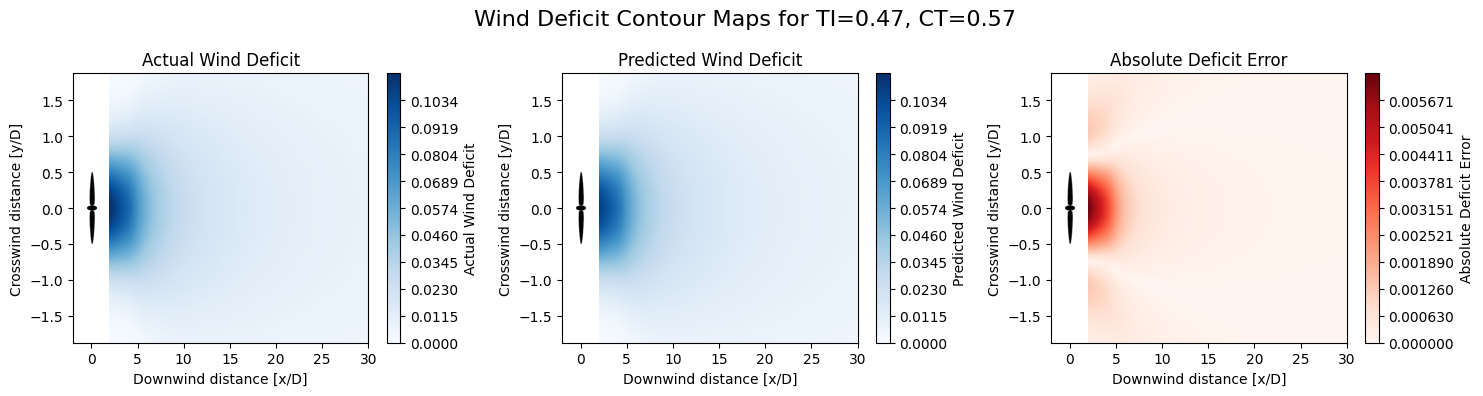

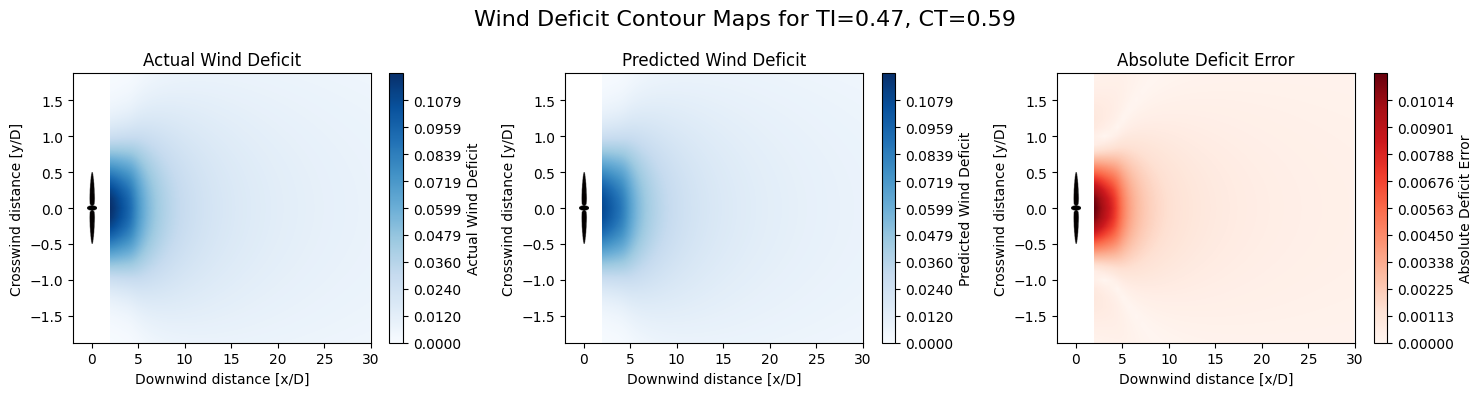

In [10]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset)//num_cells
field_indices = list(range(num_fields))
#random.shuffle(field_indices)

for field_idx in field_indices[2028:2030]:
    ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
    plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')